In [4]:
from IPython.display import IFrame
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
import sys 
sys.path.insert(0, '../code/functions')
from connectLib import clusterThresh
import connectLib as cLib

from __future__ import print_function, unicode_literals
from builtins import open

from future import standard_library
standard_library.install_aliases()
import nibabel 

import nibabel as nib

import os
import urllib.request
import urllib.error
import urllib.parse
from nipype.interfaces.ants import Registration
import sys 
sys.path.insert(0, '../../../antsbin')

import numpy as np
from nibabel.testing import data_path
import pandas as pd 
from libtiff import TIFF
from medpy.io import save
from PIL import Image
import nibabel as nb

from mouseVis import generateVoxHist
import scipy.ndimage as ndimage
from connectLib import *
import operator
from scipy.spatial import KDTree
import pipeline as pLib

# Algorithm

## Description 

The total registration algorithm will report synapse correspondance across timepoints.

**Inputs** 
1. fixed image
2. moving image
3. volume threshold lower fence 
4. volume threshold upper fence


**Outputs** 
1. The list of clusters at the first timepoint

**Pseudocode** 

1. Volume Threshold + Adaptive Threshold fixed image
2. Connected components + volume threshold + adaptive threshold on moving image
3. ANTs registration on (2)
4. clusterThresh on (3) 
5. L2 centroid distance match of (4) w/ clusterThresh fixed image 
        At this point, we have that "color X" corresponds to cluster Y in the fixed image
6. fixedCluster.tp2 = moving clusters of "color X" in (2)

## Actual Code

In [22]:
def knn_filter(volume, n):
    #neighborList = []
    outVolume = np.zeros_like(volume)
    #for all voxels in volume
    for z in range(volume.shape[0]):
        for y in range(volume.shape[1]):
            for x in range(volume.shape[2]):
                #get all valid neighbors
                neighbors = []
                for a in (-1, 1):
                    try:
                        neighbors.append(volume[z][y+a][x])
                        neighbors.append(volume[z][y][x+a])

                    #just keep going and append nothing if on edge
                    except IndexError:
                        continue

                #if at least half of your neighbors are true, be true
                #neighborList.append(np.count_nonzero(neighbors))
                if np.count_nonzero(neighbors) >= n:
                    outVolume[z][y][x] = 1
                else:
                    outVolume[z][y][x] = 0

    return outVolume
def pipeline(fixedImg, movingImg, lowerFence = 0, upperFence = 180):

    fixedImgLandmarks = fixedImg[1]
    movingImgLandmarks = movingImg[1]

    print('running adaptive threshold')
    fixedImg = cLib.adaptiveThreshold(fixedImg[0], 64, 64)
    movingImg = cLib.adaptiveThreshold(movingImg[0], 64, 64)
    ##Volume Thresholding Fixed Img

    print('performing knn filtering')
    #perform knn filtering
    fixedImg = knn_filter(fixedImg, 1)
    movingImg= knn_filter(movingImg, 1)

    # the connectivity structure matrix
    s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]

    print('extracting connected components')
    # find connected components
    fixedImg, nr_objects = ndimage.label(fixedImg, s)


    print('thresholding by volume')
    #volume thresholding with upperFence
    mask = fixedImg > fixedImg.mean()
    sizes = ndimage.sum(mask, fixedImg, range(nr_objects + 1))
    mask_size = sizes > upperFence
    remove_pixel = mask_size[fixedImg]
    fixedImg[remove_pixel] = 0
    fixedImg, nr_objects = ndimage.label(fixedImg, s)


    if not lowerFence == 0:
        #volume thresholding with upperFence
        mask = fixedImg > fixedImg.mean()
        sizes = ndimage.sum(mask, fixedImg, range(nr_objects + 1))
        mask_size = sizes < lowerFence
        remove_pixel = mask_size[fixedImg]
        fixedImg[remove_pixel] = 0
        fixedImg, nr_objects = ndimage.label(fixedImg, s)

    ##Connected Components + Volume Thresholding On Moving Image

    # find connected components
    labeled, nr_objects = ndimage.label(movingImg, s)

    #volume thresholding with upperFence
    mask = labeled > labeled.mean()
    sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
    mask_size = sizes > upperFence
    remove_pixel = mask_size[labeled]
    labeled[remove_pixel] = 0
    labeled, nr_objects = ndimage.label(labeled, s)

    if not lowerFence == 0:
        #volume thresholding with lowerFence
        mask = labeled > labeled.mean()
        sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
        mask_size = sizes < lowerFence
        remove_pixel = mask_size[labeled]
        labeled[remove_pixel] = 0
        labeled, nr_objects = ndimage.label(labeled, s)

    print('registering clusters')
    realFixedClusters = ANTs(fixedImg, labeled, fixedImgLandmarks, movingImgLandmarks, lowerFence, upperFence)

    print('correcting mismatches')
    #filtering wrong ones
    for i in range(len(realFixedClusters)):
        volumeChangeForwards = np.abs(realFixedClusters[i].volume - realFixedClusters[i].timeRegistration.volume)/np.abs(realFixedClusters[i].volume)
        volumeChangeBackwards = np.abs(realFixedClusters[i].volume - realFixedClusters[i].timeRegistration.volume)/np.abs(realFixedClusters[i].timeRegistration.volume)
        if not (volumeChangeForwards < 2 and volumeChangeBackwards < 2):
            realFixedClusters[i].timeRegistration.members = (-1, -1, -1)
            realFixedClusters[i].timeRegistration.volume = -1

    return realFixedClusters

In [42]:
def ANTs(fixedImg, movingImg, fixedImgLandmarks, movingImgLandmarks, lowerFence, upperFence, r = 5000):
    img2 = nib.Nifti1Image(fixedImgLandmarks, np.eye(4))
    nb.save(img2, 'fixed.nii')
    img3 = nib.Nifti1Image(movingImgLandmarks, np.eye(4))
    nb.save(img3, 'moving.nii')
    reg = Registration()
    reg.inputs.fixed_image = 'fixed.nii'
    reg.inputs.moving_image = 'moving.nii'
    reg.inputs.output_transform_prefix = 'thisTransform'
    reg.inputs.output_warped_image = 'registered.nii.gz'
    reg.inputs.output_transform_prefix = "output_"
    reg.inputs.transforms = ['Translation', 'Rigid', 'Affine']
    reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,)]
    reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3)
    reg.inputs.dimension = 3
    reg.inputs.write_composite_transform = True
    reg.inputs.collapse_output_transforms = False
    reg.inputs.metric = ['MeanSquares'] * 3
    reg.inputs.metric_weight = [1] * 3
    reg.inputs.radius_or_number_of_bins = [32] * 3
    reg.inputs.sampling_strategy = ['Regular'] * 3
    reg.inputs.sampling_percentage = [0.3] * 3
    reg.inputs.convergence_threshold = [1.e-8] * 3
    reg.inputs.convergence_window_size = [20] * 3
    reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3
    reg.inputs.sigma_units = ['vox'] * 3
    reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2
    reg.inputs.use_estimate_learning_rate_once = [True] * 3
    reg.inputs.use_histogram_matching = [False] * 3
    reg.inputs.initial_moving_transform_com = True
    reg.run()
    
    img2 = nib.Nifti1Image(fixedImg, np.eye(4))
    nb.save(img2, 'fixed.nii')
    img3 = nib.Nifti1Image(movingImg, np.eye(4))
    nb.save(img3, 'moving.nii')
    reg.inputs.fixed_image = 'fixed.nii'
    reg.inputs.moving_image = 'moving.nii'
    reg.initial_moving_transform = 'transform0DerivedInitialMovingTranslation.mat'
    reg.run()
    
    

    real_registered = os.path.join('registered.nii.gz')
    img = nib.load(real_registered)
    real_registered_img = img.get_data()

    registeredClusters = cLib.clusterThresh(real_registered_img, lowerFence, upperFence)
    fixedClusters = cLib.clusterThresh(fixedImg, lowerFence, upperFence)
    movingClusters = cLib.clusterThresh(movingImg, lowerFence, upperFence)

    #l2 centroid match, capped at r
    A = [elem.getCentroid() for elem in fixedClusters]
    B = [elem.getCentroid() for elem in movingClusters]

    tree = KDTree(B)
    for baseIdx, a in enumerate(A):
        dist, idx = tree.query(a, k=1, distance_upper_bound = r)
        if dist == float('Inf'):
            fixedClusters[baseIdx].timeRegistration=Cluster([[-1, -1, -1]])
        else:
            fixedClusters[baseIdx].timeRegistration=movingClusters[idx]

    return fixedClusters

In [4]:
def adaptiveThreshold(inImg, sx, sy):
    max = np.max(inImg)
    outImg = np.zeros_like(inImg)
    shape = outImg.shape
    sz = shape[0]
    subzLen = shape[0]/sz
    subYLen = shape[1]/sy
    subxLen = shape[2]/sx
    for zInc in range(1, sz + 1):
        for yInc in range(1, sy + 1):
            for xInc in range(1, sx + 1):
                sub = inImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen]
                subThresh = binaryThreshold(sub, 30)
                outImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen] = subThresh
    return outImg

In [333]:
def clusterThresh(volume, lowerFence=0, upperFence=250):
    # the connectivity structure matrix
    s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]

    # find connected components
    labeled, nr_objects = ndimage.label(volume, s)

    #volume thresholding with upperFence
    mask = labeled > labeled.mean()
    sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
    mask_size = sizes > upperFence
    remove_pixel = mask_size[labeled]
    labeled[remove_pixel] = 0
    labeled, nr_objects = ndimage.label(labeled, s)

    if not lowerFence == 0:
        #volume thresholding with lowerFence
        mask = labeled > labeled.mean()
        sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
        mask_size = sizes < lowerFence
        remove_pixel = mask_size[labeled]
        labeled[remove_pixel] = 0
        labeled, nr_objects = ndimage.label(labeled, s)

    #convert labeled to Sparse
    sparseLabeledIm = np.empty(len(labeled), dtype=object)
    for i in range(len(labeled)):
        sparseLabeledIm[i] = sparse.csr_matrix(labeled[i])

    clusterList = []

    #converting to clusterList
    for label in range(1, nr_objects + 1):

        memberList = []
        memberListWithZ = []
        for z in range(len(sparseLabeledIm)):
            memberListWithoutZ = np.argwhere(sparseLabeledIm[z] == label)
            memberListWithZ = [[z] + list(tup) for tup in memberListWithoutZ]
            memberList.extend(memberListWithZ)

        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))

    return clusterList

In [46]:
class Cluster:
    def __init__(self, members):
        self.members = members
        self.volume = self.getVolume()

    def getVolume(self):
        return len(self.members)

    def getCentroid(self):
        unzipList = zip(*self.members)
        listZ = unzipList[0]
        listY = unzipList[1]
        listX = unzipList[2]
        return [np.average(listZ), np.average(listY), np.average(listX)]

    def getStdDeviation(self):
        unzipList = zip(*self.members)
        listZ = unzipList[0]
        listY = unzipList[1]
        listX = unzipList[2]
        listOfDistances = []
        for location in self.members:
            listOfDistances.append(math.sqrt((location[0]-self.centroid[0])**2 + (location[1]-self.centroid[1])**2 + (location[2]-self.centroid[2])**2))
        stdDevDistance = np.std(listOfDistances)
        return stdDevDistance

    def probSphere(self):
        unzipList = zip(*self.members)
        listZ = unzipList[0]
        listY = unzipList[1]
        listX = unzipList[2]
        volume = ((max(listZ) - min(listZ) + 1)*(max(listY) - min(listY) + 1)*(max(listX) - min(listX) + 1))
        ratio = len(self.members)*1.0/volume
        return 1 - abs(ratio/(math.pi/6) - 1)

    def getMembers(self):
        return self.members

## Predicted Conditions 
ANTs will work well when the key features of an object to not change (i.e. a donut doesn't become a line). 

## Predictable Data Sets

**The Good Data Set:**

**Description:** The good data set is 2 100x100 volumes containing 3 clusters with value of 1. Every other value in the volume is 0. 

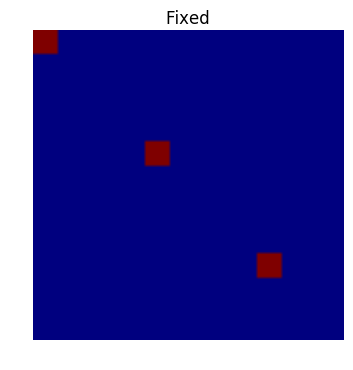

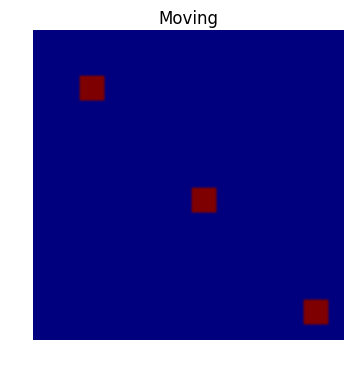

In [2]:
simEasyFixed = np.zeros((1, 100, 100))
for i in range(4):
    for j in range(4):
        simEasyFixed[0, 18*(2*j): 18*(2*j) + 8, 18*(2*j): 18*(2*j) + 8] = 1

simEasyMoving = np.zeros((1, 100, 100))
for i in range(4):
    for j in range(4):
        simEasyMoving[0, 18*(2*j) + 15: 18*(2*j + 1) + 5, 18*(2*j) + 15: 18*(2*j + 1) + 5] = 1
        
plt.imshow(simEasyFixed[0])
plt.axis('off')
plt.title('Fixed')
plt.show()

plt.imshow(simEasyMoving[0])
plt.axis('off')
plt.title('Moving')
plt.show()

**The Bad Data Set:**

**Description:** The bad data set is 2 100x100 volumes, one containing 2 clusters, one containing 3 with value of 1. Every other value in the volume is 0. 

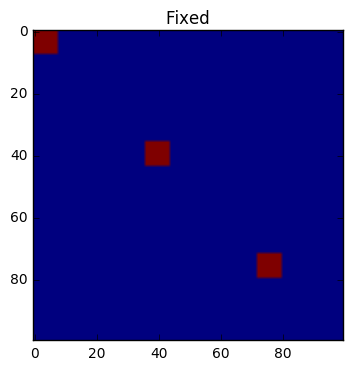

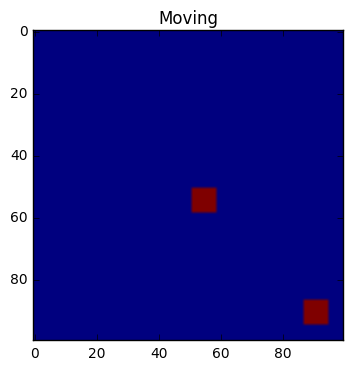

In [28]:
simBadFixed = np.zeros((1, 100, 100))
for i in range(4):
    for j in range(4):
        simBadFixed[0, 18*(2*j): 18*(2*j) + 8, 18*(2*j): 18*(2*j) + 8] = 1

simBadMoving = np.zeros((1, 100, 100))
for i in range(1, 4):
    for j in range(1, 4):
        simBadMoving[0, 18*(2*j) + 15: 18*(2*j + 1) + 5, 18*(2*j) + 15: 18*(2*j + 1) + 5] = 1
        
plt.imshow(simBadFixed[0])
plt.title('Fixed')
plt.show()

plt.imshow(simBadMoving[0])
plt.title('Moving')
plt.show()

### Toy Good Data Prediction
**Good Data Prediction: ** 
I predict that the good data will be perfectly aligned. 

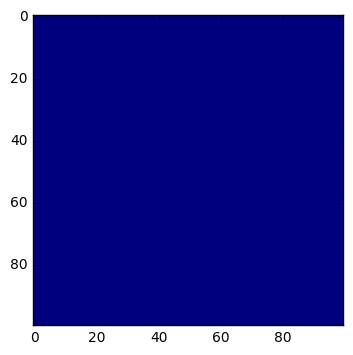

In [9]:
plt.imshow(adaptiveThreshold(simEasyFixed, 1, 1)[0])
plt.show()

In [5]:
fClusters = pLib.pipeline(simEasyFixed, simEasyMoving, lowerFence = 0, upperFence = 1000)

## Easy Simulation Analysis

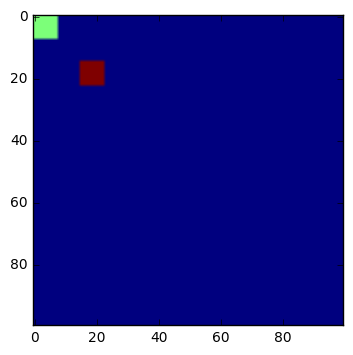

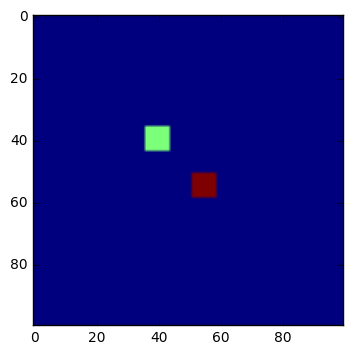

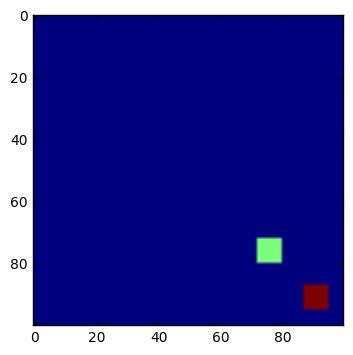

In [6]:
for i in range(len(fClusters)):
    displayIm = np.zeros_like(simEasyFixed)
    for j in range(len(fClusters[i].members)):
        fMember = fClusters[i].members[j]
        displayIm[fMember[0], fMember[1], fMember[2]] = 1
    for k in range(len(fClusters[i].timeRegistration.members)):
        rMember = fClusters[i].timeRegistration.members[k]
        displayIm[rMember[0], rMember[1], rMember[2]] = 2
    plt.imshow(displayIm[0])
    plt.show()

As predicted, the data registered functionally perfectly. 

### Toy Bad Data Prediction
**Bad Data Prediction: ** 
I predict that the bad data will only register 2 of the clusters.

## Difficult Simulation Analysis

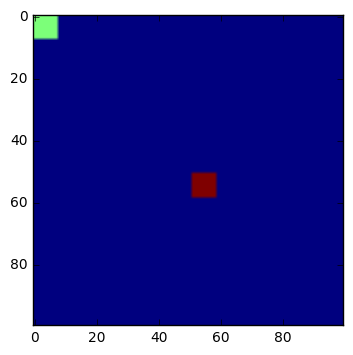

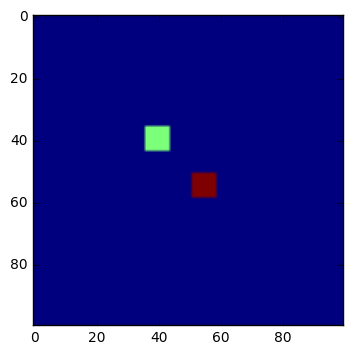

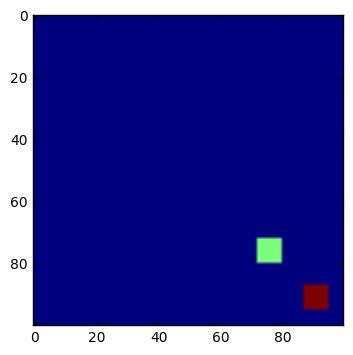

In [263]:
for i in range(0, len(fixedClusters)):
    displayIm = np.zeros_like(simBadFixed)
    for j in range(len(fixedClusters[i].members)):
        fMember = fixedClusters[i].members[j]
        displayIm[fMember[0], fMember[1], fMember[2]] = 1
    for k in range(len(fixedClusters[i].timeRegistration.members)):
        rMember = fixedClusters[i].timeRegistration.members[k]
        displayIm[rMember[0], rMember[1], rMember[2]] = 2
    plt.imshow(displayIm[0])
    plt.show()

## Real Data

### Load data, convert to proper format

In [6]:
import sys
sys.path.append('../code/functions')

import pickle

import matplotlib.pyplot as plt

from tiffIO import loadTiff, unzipChannels
from connectLib import adaptiveThreshold

import numpy as np

In [7]:
tp2ChanList = unzipChannels(loadTiff('../data/SEP-GluA1-KI_tp2.tif'))
tp3ChanList = unzipChannels(loadTiff('../data/SEP-GluA1-KI_tp3.tif'))

In [26]:
#First slice only
tp2slice = tp2ChanList[0:2, 124:125, 0:512, 0:512]
tp3slice = tp3ChanList[0:2, 124:125, 0:512, 0:512]

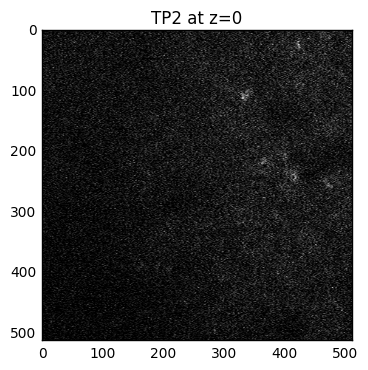

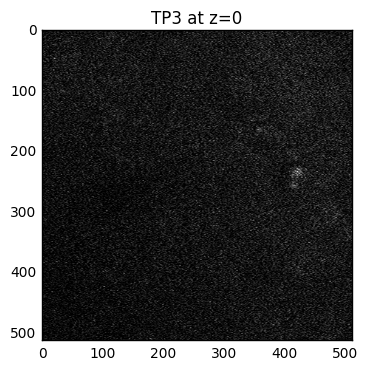

In [27]:
fig = plt.figure()
plt.imshow(tp2slice[0][0], cmap='gray')
plt.title('TP2 at z=0')
plt.show()

fig = plt.figure()
plt.imshow(tp3slice[0][0], cmap='gray')
plt.title('TP3 at z=0')
plt.show()

### Before

In [20]:
%%time
realFixedClusters = pLib.pipeline(tp2slice, tp3slice, lowerFence = 10, upperFence = 100)

running adaptive threshold
performing knn filtering
extracting connected components
thresholding by volume
registering clusters
correcting mismatches
CPU times: user 19.2 s, sys: 1.24 s, total: 20.4 s
Wall time: 4min 11s


In [21]:
differences = []
for cluster in realFixedClusters:
    difference = cluster.timeRegistration.volume - cluster.volume
    differenceProportion = difference*1.0/cluster.volume
    differences.append(differenceProportion)

In [22]:
fixedVolumes = []
movingVolumes = []
for cluster in realFixedClusters:
    fixedVolumes.append(cluster.volume)
    movingVolumes.append(cluster.timeRegistration.volume)
accrossTimeVolumes = [(fixedVolumes[i], movingVolumes[i]) for i in range(len(fixedVolumes))]

In [23]:
print("Average Change in Volume: " + str(100* np.mean(differences)) + "%")

Average Change in Volume: -29.8804833048%


In [25]:
count = 0
for i in range(len(accrossTimeVolumes)):
    if (accrossTimeVolumes[i][1] > 0):
        count = count + 1
print(count * 1.0 / len(accrossTimeVolumes))

0.615732683606


### After

In [29]:
%%time
realFixedClusters = pLib.pipeline(tp2slice, tp3slice, lowerFence = 10, upperFence = 100)

running adaptive threshold
performing knn filtering
extracting connected components
thresholding by volume
registering clusters
correcting mismatches
CPU times: user 4.21 s, sys: 191 ms, total: 4.4 s
Wall time: 47.7 s


In [30]:
differences = []
for cluster in realFixedClusters:
    difference = cluster.volume - cluster.timeRegistration.volume
    differenceProportion = difference*1.0/cluster.volume
    differences.append(differenceProportion)

In [31]:
fixedVolumes = []
movingVolumes = []
for cluster in realFixedClusters:
    fixedVolumes.append(cluster.volume)
    movingVolumes.append(cluster.timeRegistration.volume)
accrossTimeVolumes = [(fixedVolumes[i], movingVolumes[i]) for i in range(len(fixedVolumes))]

In [32]:
print("Average Change in Volume: " + str(100* np.mean(differences)) + "%")

Average Change in Volume: 34.148808272%


In [39]:
count = 0
for i in range(len(accrossTimeVolumes)):
    if (accrossTimeVolumes[i][1] > 0):
        count = count + 1
print('Proportion Registered Correctly: ' + str(count * 1.0 / len(accrossTimeVolumes)))

Proportion Registered Correctly: 0.583946488294
